In [1]:
using Pkg 
Pkg.activate("..")

  Activating project at `~/code/PhasorNetworks.jl`


In [2]:
include("../src/PhasorNetworks.jl")
using .PhasorNetworks, Plots, DifferentialEquations

┌ Warning: Replacing docs for `Main.PhasorNetworks.gaussian_kernel :: Tuple{AbstractArray, Real, Real}` in module `Main.PhasorNetworks`
└ @ Base.Docs docs/Docs.jl:243


In [3]:
using Lux, MLUtils, MLDatasets, OneHotArrays, Statistics, Test, LuxCUDA
using Random: Xoshiro, AbstractRNG
using Base: @kwdef
using Zygote: withgradient
using Optimisers, ComponentArrays
using Statistics: mean
using LinearAlgebra: diag
using PhasorNetworks: bind
using Distributions: Normal
using DifferentialEquations: Heun, Tsit5

[ Info: Precompiling PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c] (cache misses: include_dependency fsize change (2), wrong dep version loaded (2), mismatched flags (14))
ERROR: Method overwriting is not permitted during Module precompilation. Use `__precompile__(false)` to opt-out of precompilation.
┌ Info: Skipping precompilation due to precompilable error. Importing PhasorNetworks [c32d742c-e486-48f1-8804-9f6fb4d3f42c].
└   exception = Error when precompiling module, potentially caused by a __precompile__(false) declaration in the module.
┌ Warning: Replacing docs for `PhasorNetworks.gaussian_kernel :: Tuple{AbstractArray, Real, Real}` in module `PhasorNetworks`
└ @ Base.Docs docs/Docs.jl:243


In [4]:
solver_args = Dict(:adaptive => false, :dt => 0.01)

Dict{Symbol, Real} with 2 entries:
  :adaptive => false
  :dt       => 0.01

In [5]:
spk_args = SpikingArgs(threshold = 0.001,
                    solver=Tsit5(), 
                    solver_args = solver_args)

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)


In [6]:
cdev = cpu_device()
gdev = gpu_device()

(::CUDADevice{Nothing, Missing}) (generic function with 1 method)

In [7]:
args = Args(batchsize = 128, epochs = 25, use_cuda = true)

Args(0.0003, 128, 25, true, Xoshiro(0xa379de7eeeb2a4e8, 0x953dccb6b532b3af, 0xf597b8ff8cfd652a, 0xccd7337c571680d1, 0xc90c4a0730db3f7e))

In [8]:
train_data = MLDatasets.FashionMNIST(split=:train)
test_data = MLDatasets.FashionMNIST(split=:test)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [9]:
train_loader =DataLoader(train_data, batchsize=args.batchsize)

469-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [10]:
test_loader =DataLoader(test_data, batchsize=args.batchsize)

79-element DataLoader(::FashionMNIST, batchsize=128)
  with first element:
  (; features = 28×28×128 Array{Float32, 3}, targets = 128-element Vector{Int64})

In [11]:
struct OneHotTestLoader
    loader::DataLoader
    n_classes::Int
end

function Base.iterate(loader::OneHotTestLoader)
    state = iterate(loader.loader)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

function Base.iterate(loader::OneHotTestLoader, loader_state)
    state = iterate(loader.loader, loader_state)
    state === nothing && return nothing
    (x, y), loader_state = state
    y_onehot = onehotbatch(y, 0:(loader.n_classes-1))
    return (x, y_onehot), loader_state
end

Base.length(loader::OneHotTestLoader) = length(loader.loader)

test_loader_onehot = OneHotTestLoader(test_loader, 10)

OneHotTestLoader(DataLoader(::FashionMNIST, batchsize=128), 10)

In [12]:
x0, y0 = first(train_loader)

(features = Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  6, 7, 5, 5, 9, 2, 2, 2, 7, 6])

In [17]:
import .PhasorNetworks: phase_to_current, arc_gaussian_kernel

In [21]:
using Zygote: ignore_derivatives

In [18]:
function phase_to_current(phases::AbstractArray; spk_args::SpikingArgs, offset::Real = 0.0f0, tspan::Tuple{<:Real, <:Real}, rng::Union{AbstractRNG, Nothing} = nothing, zeta::Real=Float32(0.0))
    shape = size(phases)
    
    function inner(t::Real)
        p = time_to_phase([t,], spk_args = spk_args, offset = offset)[1]
        current_kernel = x -> arc_gaussian_kernel(x, p, spk_args.t_window * period_to_angfreq(spk_args.t_period))
        impulses = current_kernel(phases)

        ignore_derivatives() do
            if zeta > 0.0f0
                noise = zeta .* randn(rng, Float32, size(impulses))
                impulses .+= noise
            end
        end

        return impulses
    end

    current = LocalCurrent(inner, shape, offset)
    call = CurrentCall(current, spk_args, tspan)

    return call
end

phase_to_current (generic function with 1 method)

In [19]:
xt = phase_to_current(reshape(x0, (28^2, 128)), spk_args=spk_args, tspan=(0.0, 10.0))

CurrentCall(LocalCurrent(var"#inner#10"{SpikingArgs, Float32, Nothing, Float32, Matrix{Float32}}(Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, 0.0f0, nothing, 0.0f0, Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]), (784, 128), 0.0f0), Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.01 (s)
Threshold: 0.001 (V)
, (0.0, 10.0))

In [26]:
islice = stack([xt(ts) for ts in 0.0:0.01:1.5]);

In [27]:
size(islice)

(784, 128, 151)

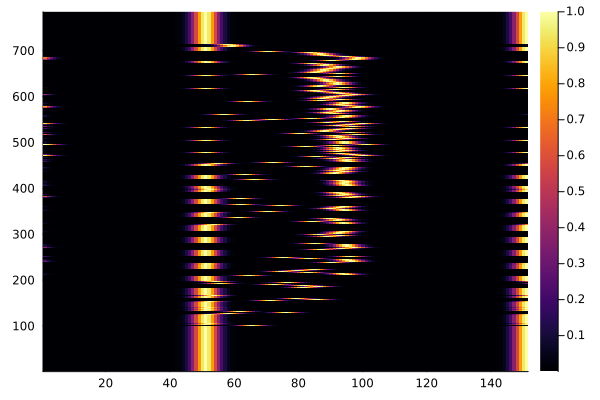

In [28]:
heatmap(islice[:,1,:])

In [38]:
network = Chain(PhasorDense(784 => 128, soft_angle, return_solution=true),)

Chain(
    layer_1 = PhasorDense(
        layer = Dense(784 => 128, use_bias=false),  # 100_352 parameters
        bias = ComplexBias((128,)),               # 256 parameters
    ),
)         # Total: 100_608 parameters,
          #        plus 0 states.

In [39]:
ps, st = Lux.setup(args.rng, network)

((layer_1 = (layer = (weight = Float32[0.039607193 0.01944627 … 0.00022751502 -0.057039727; -0.009618023 -0.024282424 … 0.009979601 0.02718339; … ; 0.03448291 -0.053464845 … 0.034305 0.045881137; -0.023469754 -0.056783054 … -0.0009875257 0.022305306],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])),), (layer_1 = (layer = NamedTuple(), bias = NamedTuple()),))

In [40]:
ps

(layer_1 = (layer = (weight = Float32[0.039607193 0.01944627 … 0.00022751502 -0.057039727; -0.009618023 -0.024282424 … 0.009979601 0.02718339; … ; 0.03448291 -0.053464845 … 0.034305 0.045881137; -0.023469754 -0.056783054 … -0.0009875257 0.022305306],), bias = (bias_real = Float32[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], bias_imag = Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])),)

In [41]:
u1,_ = network(xt, ps, st)

(Matrix{Float32}[[0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264; … ; 0.043107264 0.043107264 … 0.043107264 0.043107264; 0.043107264 0.043107264 … 0.043107264 0.043107264], [-0.043787014 0.00044608442 … -0.04388185 -0.04286415; -0.04319385 -0.04478067 … -0.04227535 -0.043724734; … ; -0.044112045 -0.04453898 … 0.0004295053 -0.04328757; -0.043508314 0.0004164191 … 0.0005274518 -0.042980075], [-0.044228263 0.0008918599 … -0.044368677 -0.04265786; -0.04314316 -0.04601032 … -0.042276613 -0.044158928; … ; -0.04492275 -0.04540717 … 0.0008403848 -0.043323472; -0.04409194 0.00077887654 … 0.0010538163 -0.042860046], [-0.04447742 0.0012902304 … -0.044634774 -0.042471122; -0.04318985 -0.046765402 … -0.042260688 -0.044413343; … ; -0.045434996 -0.045850042 … 0.001205971 -0.043279726; -0.0445863 0.0010583667 … 0.0015321946 -0.04273294], [-0.044587113 0.00160622 … -0.044750165 -0.042298216; -0.043542795 -0.047147598 … -0.042237695 -0.044526167; … ;

In [42]:
u1 |> size

(1001,)

In [44]:
u1s = stack(u1);

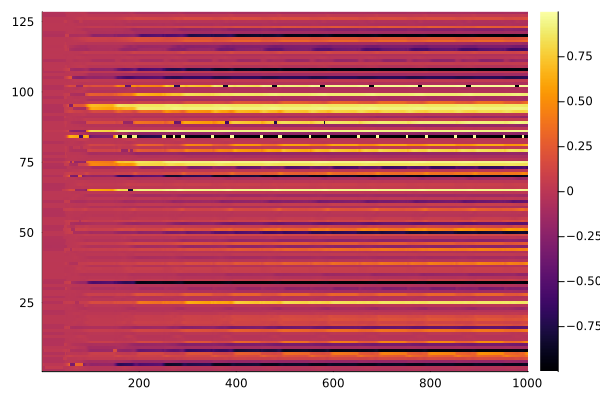

In [45]:
heatmap(u1s[:,1,:])

In [50]:
function potential_to_current(potential::AbstractArray{<:Complex}; spk_args::SpikingArgs, steepness::Real=10.0)
    threshold = spk_args.threshold
    phase_window = spk_args.t_window / spk_args.t_period
    abs_scale = sigmoid_fast(abs.(potential) ./ steepness)
    phase_scale = exp.(-1.0f0 .* (complex_to_angle(potential).^2 / (2.0f0 * phase_window ^ 2.0f0)))
    current = abs_scale .* phase_scale
    return current
end 

potential_to_current (generic function with 1 method)

In [47]:
spk_args.threshold

0.001f0

In [49]:
spk_args.t_period

1.0f0

In [48]:
spk_args.t_window

0.01f0

In [37]:
uslice = stack([u1(ts) for ts in 0.0:0.01:1.50]);

LoadError: MethodError: objects of type SpikingCall are not callable
The object of type `SpikingCall` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.